In [2]:
pip install overpy

In [3]:
import overpy
import folium
import pandas as pd
from folium.plugins import HeatMap

# Initialize Overpass API
api = overpy.Overpass()

# Define Overpass Query to get hospitals, clinics, and health care centers in Kano State
query = """
[out:json];
area["name"="Kano"]->.searchArea;
(
  node["amenity"="hospital"](area.searchArea);
  node["amenity"="clinic"](area.searchArea);
  node["healthcare"="health_post"](area.searchArea);
  node["healthcare"="health_centre"](area.searchArea);
  way["amenity"="hospital"](area.searchArea);
  way["amenity"="clinic"](area.searchArea);
  way["healthcare"="health_post"](area.searchArea);
  way["healthcare"="health_centre"](area.searchArea);
  relation["amenity"="hospital"](area.searchArea);
  relation["amenity"="clinic"](area.searchArea);
  relation["healthcare"="health_post"](area.searchArea);
  relation["healthcare"="health_centre"](area.searchArea);
);
out body;
>;
out skel qt;
"""

# Execute the query and fetch data from OSM
result = api.query(query)

# Process the data into a list
hospital_data = []
for node in result.nodes:
    hospital_data.append({
        'name': node.tags.get('name', 'Unnamed'),
        'latitude': node.lat,
        'longitude': node.lon,
        'type': node.tags.get('amenity', node.tags.get('healthcare', 'unknown'))
    })

for way in result.ways:
    # For ways, calculate the average location of all the nodes in the way
    latitudes = [node.lat for node in way.nodes]
    longitudes = [node.lon for node in way.nodes]
    avg_lat = sum(latitudes) / len(latitudes)
    avg_lon = sum(longitudes) / len(longitudes)
    hospital_data.append({
        'name': way.tags.get('name', 'Unnamed'),
        'latitude': avg_lat,
        'longitude': avg_lon,
        'type': way.tags.get('amenity', way.tags.get('healthcare', 'unknown'))
    })

# Convert data to pandas DataFrame for easier handling
df_hospitals = pd.DataFrame(hospital_data)

# Filter the data based on hospital types
general_hospitals = df_hospitals[df_hospitals['type'] == 'hospital']
health_centers = df_hospitals[df_hospitals['type'] == 'health_centre']
health_posts = df_hospitals[df_hospitals['type'] == 'health_post']

# Create an interactive map centered on Kano State
kano_map = folium.Map(location=[12.0022, 8.5919], zoom_start=11)

# Create FeatureGroups for each type of healthcare facility
general_hosp_layer = folium.FeatureGroup(name="General Hospitals", overlay=True)
health_center_layer = folium.FeatureGroup(name="Health Centers", overlay=True)
health_post_layer = folium.FeatureGroup(name="Health Posts", overlay=True)

# Add General Hospitals to the map
for index, row in general_hospitals.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='red', icon='hospital-o')
    ).add_to(general_hosp_layer)

# Add Health Centers to the map
for index, row in health_centers.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='green', icon='medkit')
    ).add_to(health_center_layer)

# Add Health Posts to the map
for index, row in health_posts.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='blue', icon='plus')
    ).add_to(health_post_layer)

# Add HeatMap for visualization of healthcare density
heat_data = [[row['latitude'], row['longitude']] for index, row in df_hospitals.iterrows()]
HeatMap(heat_data).add_to(kano_map)

# Add the feature groups (layers) to the map
general_hosp_layer.add_to(kano_map)
health_center_layer.add_to(kano_map)
health_post_layer.add_to(kano_map)

# Add Layer Control to toggle between the different healthcare types
folium.LayerControl().add_to(kano_map)

# Add title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Kano State Healthcare Facilities Map</b></h3>
             '''
kano_map.get_root().html.add_child(folium.Element(title_html))

# Add a legend for the map
legend_html = '''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 150px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-plus" style="color:blue"></i>&nbsp; Health Posts<br>
     &nbsp; <i class="fa fa-medkit" style="color:green"></i>&nbsp; Health Centers<br>
     &nbsp; <i class="fa fa-hospital-o" style="color:red"></i>&nbsp; General Hospitals
      </div>
     '''
kano_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
kano_map.save("kano_hospitals_map.html")

# Display the map (only works in interactive environments like Jupyter Notebook)
kano_map


In [4]:
df_hospitals.to_csv('kano_healthcare_facilities.csv', index=False)

In [5]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load your dataset
df = pd.read_csv('kano_healthcare_facilities.csv')

# Extract facilities based on name endings
health_centres = df[df['name'].str.endswith('Health Centre')]
health_posts = df[df['name'].str.endswith('Health Post')]
general_hospitals = df[df['name'].str.contains('General Hospital')]

# Initialize the map centered around Kano
kano_map = folium.Map(location=[12.0022, 8.5919], zoom_start=11)

# Create layers for each facility type
general_hosp_layer = folium.FeatureGroup(name=f"General Hospitals (Count: {len(general_hospitals)})", overlay=True)
health_center_layer = folium.FeatureGroup(name=f"Health Centres (Count: {len(health_centres)})", overlay=True)
health_post_layer = folium.FeatureGroup(name=f"Health Posts (Count: {len(health_posts)})", overlay=True)

# Add General Hospitals to the map
for _, row in general_hospitals.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='red', icon='hospital-o')
    ).add_to(general_hosp_layer)

# Add Health Centres to the map
for _, row in health_centres.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='green', icon='medkit')
    ).add_to(health_center_layer)

# Add Health Posts to the map
for _, row in health_posts.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='blue', icon='plus')
    ).add_to(health_post_layer)

# Add HeatMap for visualizing healthcare density
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(kano_map)

# Add the layers to the map
general_hosp_layer.add_to(kano_map)
health_center_layer.add_to(kano_map)
health_post_layer.add_to(kano_map)

# Add Layer Control
folium.LayerControl().add_to(kano_map)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Kano State Healthcare Facilities Map</b></h3>
             '''
kano_map.get_root().html.add_child(folium.Element(title_html))

# Add a small legend to the top of the map, above the title
legend_html = '''
     <div style="position: fixed;
     top: 20px; left: 50px; width: 150px; height: 120px;
     border:2px solid grey; z-index:9999; font-size:12px;
     background-color:white; padding: 5px;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-hospital-o" style="color:red"></i>&nbsp; General Hospitals<br>
     &nbsp; <i class="fa fa-medkit" style="color:green"></i>&nbsp; Health Centres<br>
     &nbsp; <i class="fa fa-plus" style="color:blue"></i>&nbsp; Health Posts<br>
     </div>
     '''
kano_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
kano_map.save("kano_healthcare_map.html")

# Display the map (for interactive environments like Jupyter Notebook)
kano_map

Step-by-Step EDA:
1. Facility Count by Type
We first count the number of each healthcare facility type (General Hospitals, Health Centres, and Health Posts) to understand the overall distribution.

<ipython-input-6-8f729771523e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(facility_counts.keys()), y=list(facility_counts.values()), palette="Set2")


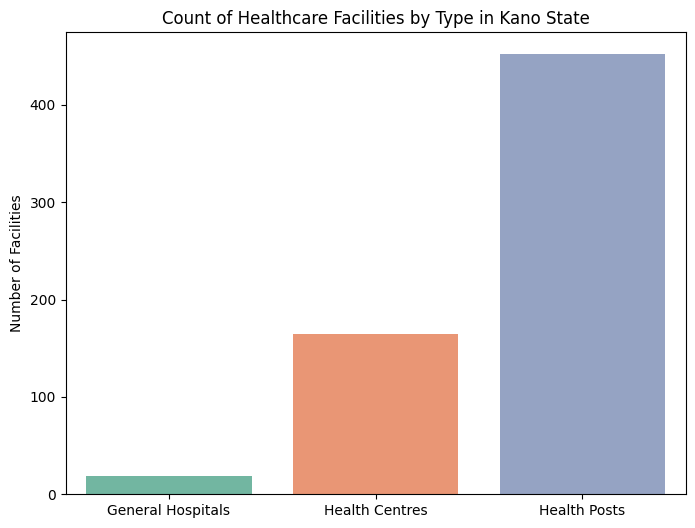

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('kano_healthcare_facilities.csv')

# Count the number of each facility type
health_centres_count = len(df[df['name'].str.endswith('Health Centre')])
health_posts_count = len(df[df['name'].str.endswith('Health Post')])
general_hospitals_count = len(df[df['name'].str.contains('General Hospital')])

# Create a bar chart for facility counts
facility_counts = {'General Hospitals': general_hospitals_count,
                   'Health Centres': health_centres_count,
                   'Health Posts': health_posts_count}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(facility_counts.keys()), y=list(facility_counts.values()), palette="Set2")
plt.title('Count of Healthcare Facilities by Type in Kano State')
plt.ylabel('Number of Facilities')
plt.show()

2. Geographic Distribution

We'll visualize the geographic distribution of each facility type on a scatter plot using latitude and longitude.

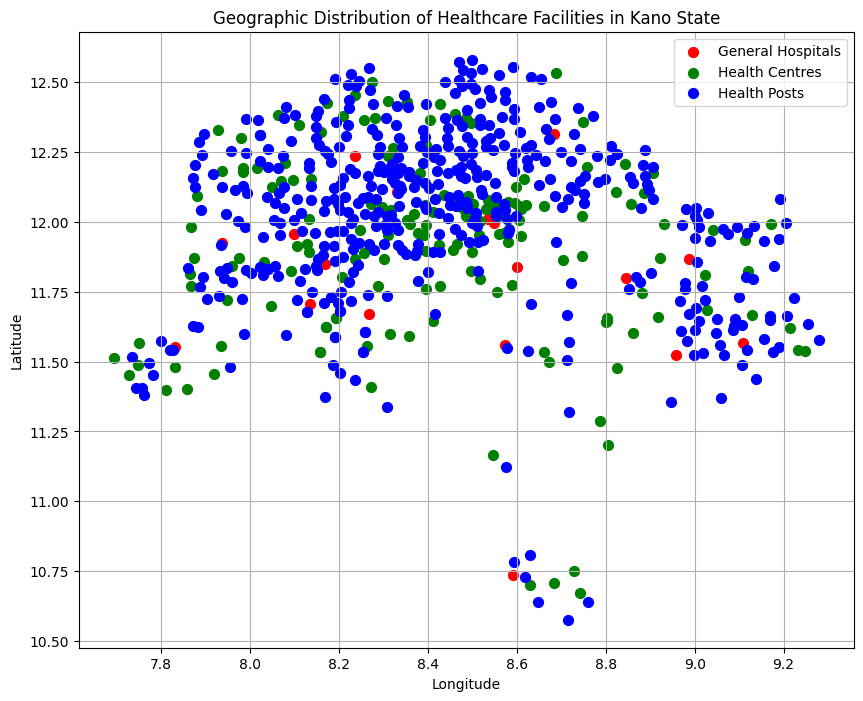

In [7]:
# Scatter plot for geographic distribution
plt.figure(figsize=(10, 8))

# General Hospitals
general_hospitals = df[df['name'].str.contains('General Hospital')]
plt.scatter(general_hospitals['longitude'], general_hospitals['latitude'], color='red', label='General Hospitals', s=50)

# Health Centres
health_centres = df[df['name'].str.endswith('Health Centre')]
plt.scatter(health_centres['longitude'], health_centres['latitude'], color='green', label='Health Centres', s=50)

# Health Posts
health_posts = df[df['name'].str.endswith('Health Post')]
plt.scatter(health_posts['longitude'], health_posts['latitude'], color='blue', label='Health Posts', s=50)

plt.title('Geographic Distribution of Healthcare Facilities in Kano State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

3. Healthcare Density with Heatmaps

We’ll use heatmaps to understand the density of healthcare facilities. This helps in identifying both high-concentration areas and underserved regions.

In [8]:
import folium
from folium.plugins import HeatMap

# Initialize the map centered around Kano
kano_map = folium.Map(location=[12.0022, 8.5919], zoom_start=11)

# Prepare heatmap data for all facilities
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(kano_map)

# Save the heatmap to an HTML file
kano_map.save("kano_healthcare_density_map.html")

# Display the map in a Jupyter environment
kano_map


4. Clustering Analysis

We'll use a clustering algorithm (like KMeans) to identify clusters of healthcare facilities. This can help identify areas that are overserved or underserved.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


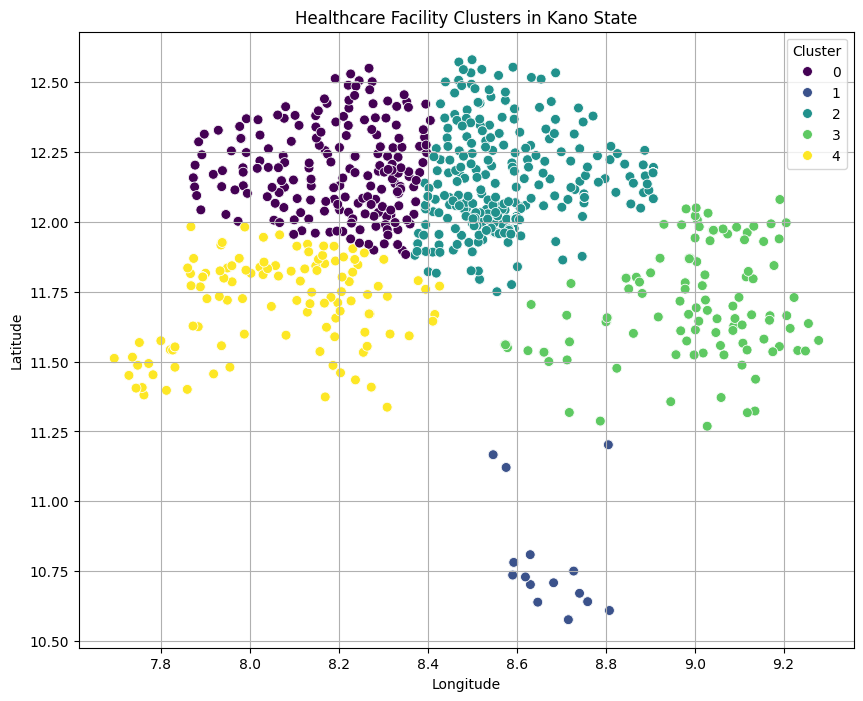

In [9]:
from sklearn.cluster import KMeans

# Prepare data for clustering
coords = df[['latitude', 'longitude']].dropna()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(coords)
df['cluster'] = kmeans.labels_

# Visualize clusters on a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='viridis', s=50)
plt.title('Healthcare Facility Clusters in Kano State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

5. Distance to Nearest Facility

Analyzing the distance between population centers and healthcare facilities can reveal underserved areas.

In [10]:
from geopy.distance import geodesic

# Example: Calculate distance between two facilities
facility_1 = (df.iloc[0]['latitude'], df.iloc[0]['longitude'])
facility_2 = (df.iloc[1]['latitude'], df.iloc[1]['longitude'])

distance = geodesic(facility_1, facility_2).kilometers
print(f"Distance between two healthcare facilities: {distance:.2f} km")

Distance between two healthcare facilities: 44.63 km


6. Healthcare Accessibility by Facility Type

We can identify underserved areas by checking which areas have only Health Posts, Health Centres, or General Hospitals, and which areas have none.

python

In [11]:
# Filter regions with only health posts or only health centres
only_health_posts = df[df['name'].str.endswith('Health Post') & ~df['name'].str.contains('Health Centre|General Hospital')]
only_health_centres = df[df['name'].str.endswith('Health Centre') & ~df['name'].str.contains('General Hospital')]
no_facility = df[~df['name'].str.contains('Health Post|Health Centre|General Hospital')]

# Display the counts
print(f"Areas with only Health Posts: {len(only_health_posts)}")
print(f"Areas with only Health Centres: {len(only_health_centres)}")
print(f"Areas with no major facility: {len(no_facility)}")

Areas with only Health Posts: 452
Areas with only Health Centres: 165
Areas with no major facility: 4393
